In [3]:
import pandas as pd
import numpy as np
from transformers import AutoModel, CLIPProcessor, AutoConfig
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import lightning.pytorch as pl
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from PIL import Image

import seaborn as sns
import os
import torchvision.transforms as T
from torchvision.transforms import Compose
from torch.utils.data import Dataset

SEED=1234542

pl.seed_everything(SEED, workers=True)

df_train=pd.read_csv('../../data/splitted/train.csv')
df_validation=pd.read_csv('../../data/splitted/validation.csv')
df_test=pd.read_csv('../../data/splitted/test.csv')

# Remove nan from caption column
df_train.fillna(value="", inplace=True)
df_validation.fillna(value="", inplace=True)
df_test.fillna(value="", inplace=True)


NUM_CLASSES= len(df_train['labels'].unique())

TEXT_USED='caption'

TRAIN_IMAGES_PATH= '../../images/train'
VALIDATION_IMAGES_PATH= '../../images/validation'
TEST_IMAGES_PATH= '../../images/test'

Global seed set to 1234542


In [4]:
label_dict={0: 'Movies', 1: 'Sports', 2: 'Music', 3: 'Opinion', 4: 'Media', 5: 'Art & Design', 6: 'Theater', 7: 'Television', 8: 'Technology', 9: 'Economy', 10: 'Books', 11: 'Style', 12: 'Travel', 13: 'Health', 14: 'Real Estate', 15: 'Dance', 16: 'Science', 17: 'Fashion', 18: 'Well', 19: 'Food', 20: 'Your Money', 21: 'Education', 22: 'Automobiles', 23: 'Global Business'}
labels_list=[]
for label in label_dict:
    labels_list.append(f'This is a news article about {label_dict[label]}')


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'openai/clip-vit-base-patch32'

pretrained_model = AutoModel.from_pretrained(MODEL_NAME)
clip_config= AutoConfig.from_pretrained(MODEL_NAME)
processor= CLIPProcessor.from_pretrained(MODEL_NAME)

In [5]:
class CustomMultimodalDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df= df
        self.img_dir = img_dir
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label_text= self.df['labels_text'].iloc[idx]
        img_path = os.path.join(self.img_dir, label_text, self.df['image_id'].iloc[idx])
        img_path=img_path + '.jpg'
        image = Image.open(img_path)
        if(image.mode != 'RGB'):
            image=image.convert('RGB')
        label = self.df['labels'].iloc[idx]
        return image, label
    
train_dataset= CustomMultimodalDataset(df_train, TRAIN_IMAGES_PATH)
validation_dataset= CustomMultimodalDataset(df_validation, VALIDATION_IMAGES_PATH)
test_dataset= CustomMultimodalDataset(df_test, TEST_IMAGES_PATH)

In [6]:
class MultimodalCollator:
    
    def __init__(self, processor=processor, augment_mode='hard', split='train', max_length=77):
        # 40 max length for vilt // 77 max length for clip
        self.processor = processor
        self.split = split
        self.max_length = max_length
        self.augment_mode = augment_mode

    def __call__(self, batch):
        images, labels = list(zip(*batch))
        encoding = self.processor(images=images, 
                                  text=labels_list, 
                                  padding=True,
                                  max_length=self.max_length,
                                  truncation=True,
                                  return_tensors='pt')
        encoding['labels']=torch.tensor(labels)
        return encoding

In [7]:
BATCH_SIZE=8

collator_train=MultimodalCollator(split='train')
collator_val=MultimodalCollator(split='val')
collator_test=MultimodalCollator(split='test')
train_loader = DataLoader(train_dataset, collate_fn=collator_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, collate_fn=collator_val, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, collate_fn=collator_test, batch_size=BATCH_SIZE)

In [8]:
class CLIPClassifier(pl.LightningModule):
    def __init__(self, model=pretrained_model,  lr=2e-5):
        super(CLIPClassifier, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        self.lr=lr
        # En el train hacemos media de medias
        self.train_loss=[]
        self.train_accs=[]
        self.train_f1s=[]
        
        
        # Aqui computamos las métricas con todo para mayor precision   
        self.val_loss=[]             
        self.all_val_y_true=[]
        self.all_val_y_pred=[]
        
        self.model = model
        # Freeze model parameters
        for param in self.model.parameters():
            param.requires_grad = False
        
    def compute_outputs(self, input_ids, attention_mask, pixel_values):
        outputs = pretrained_model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        logits_per_image = outputs.logits_per_image # this is the image-text similarity score
        
        
        return logits_per_image
    
    def forward(self, batch):
        pixel_values = batch['pixel_values']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        x = self.compute_outputs(input_ids, attention_mask, pixel_values)
        return x
    
    def training_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        #Compute the output logits
        logits = self.compute_outputs(input_ids, attention_mask, pixel_values)
        #Compute metrics
        loss=self.criterion(logits,labels)
        preds = torch.argmax(logits, dim=-1)
        acc=accuracy_score(y_true=labels.tolist(), y_pred=preds.tolist())
        f1=f1_score(y_true=labels.tolist(), y_pred=preds.tolist(), average='macro')
        self.train_loss.append(loss)
        self.train_accs.append(acc)
        self.train_f1s.append(f1)
        
        return loss
    
    def on_train_epoch_end(self):
        # outs is a list of whatever you returned in `validation_step`
        mean_loss = sum(self.train_loss)/len(self.train_loss)
        mean_acc=sum(self.train_accs)/len(self.train_accs)
        mean_f1=sum(self.train_f1s)/len(self.train_f1s)
        
        self.log("train_loss", mean_loss)
        self.log("train_acc", mean_acc)
        self.log("train_f1", mean_f1)
        
        self.train_loss=[]
        self.train_accs=[]
        self.train_f1s=[]
    
    
    def validation_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        #Compute the output logits
        logits = self.compute_outputs(input_ids, attention_mask, pixel_values)
        #Compute metrics
        loss=self.criterion(logits,labels)
        preds = torch.argmax(logits, dim=-1)
        
        self.val_loss.append(loss)
        
        self.all_val_y_true.extend(labels.tolist())
        self.all_val_y_pred.extend(preds.tolist())
        return loss
    
    def on_validation_epoch_end(self):
        # outs is a list of whatever you returned in `validation_step`
        mean_loss = sum(self.val_loss)/len(self.val_loss)
        
        acc= accuracy_score(y_true=self.all_val_y_true, y_pred=self.all_val_y_pred)
        f1= f1_score(y_true=self.all_val_y_true, y_pred=self.all_val_y_pred, average='macro')
        
        self.log("val_loss", mean_loss)
        self.log("val_acc", acc)
        self.log("val_f1", f1)
        
        self.val_loss=[]
        self.all_val_y_true=[]
        self.all_val_y_pred=[]
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, amsgrad=True, weight_decay=0.01)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=5)
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val_loss",
                    },
                }

In [9]:
train_loader_predicting = DataLoader(train_dataset, collate_fn=collator_train, batch_size=BATCH_SIZE)

my_model=CLIPClassifier(pretrained_model)
trainer=pl.Trainer(accelerator="gpu", devices=[3], deterministic=True, max_epochs=60, precision='16-mixed', accumulate_grad_batches=2)

#predictions_test = trainer.predict(my_model, test_loader)
#predictions_val = trainer.predict(my_model, validation_loader)
predictions_train = trainer.predict(my_model, train_loader_predicting)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be 

Predicting: 0it [00:00, ?it/s]

<class 'NameError'>: name 'labels_list' is not defined

In [11]:
def get_predictions(loader, predictions, split):
    # initialize the variables for storing true and predicted labels
    all_y_true = []
    all_y_pred = []

    # iterate over the batches and compute f1-score and confusion matrix for each batch
    for i, batch in enumerate(loader):
        preds=torch.argmax(predictions[i], dim=-1)
        y_pred, y_true = preds.tolist(), batch['labels'].tolist()

        # append the true and predicted labels to the corresponding lists
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

    mean_f1= f1_score(y_true=all_y_true, y_pred=all_y_pred, average='macro')
    print(f'Mean F1: {mean_f1}')
    # compute the confusion matrix
    cm = confusion_matrix(y_true=all_y_true, y_pred=all_y_pred)
      # plot the confusion matrix as a heatmap
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

    # set the plot labels
    class_names = labels_list
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(np.arange(24) + 0.5, class_names, rotation=90)
    plt.yticks(np.arange(24) + 0.5, class_names, rotation=0)

    plt.show()

Mean F1: 0.380997189672511


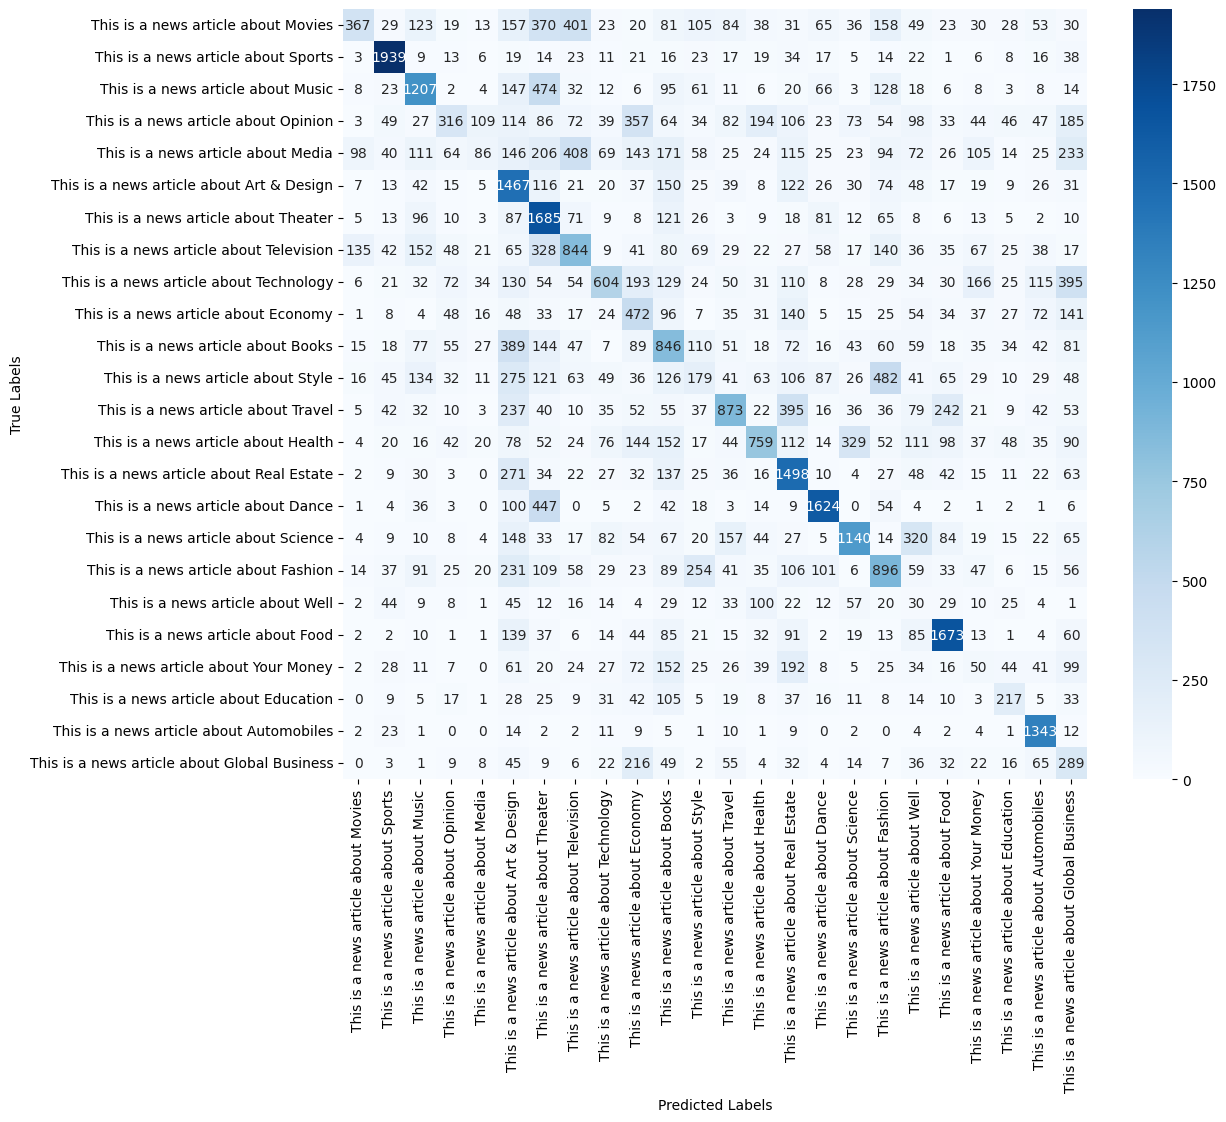

In [12]:
get_predictions(train_loader_predicting, predictions_train, split='train')

Mean F1: 0.38396628697711105


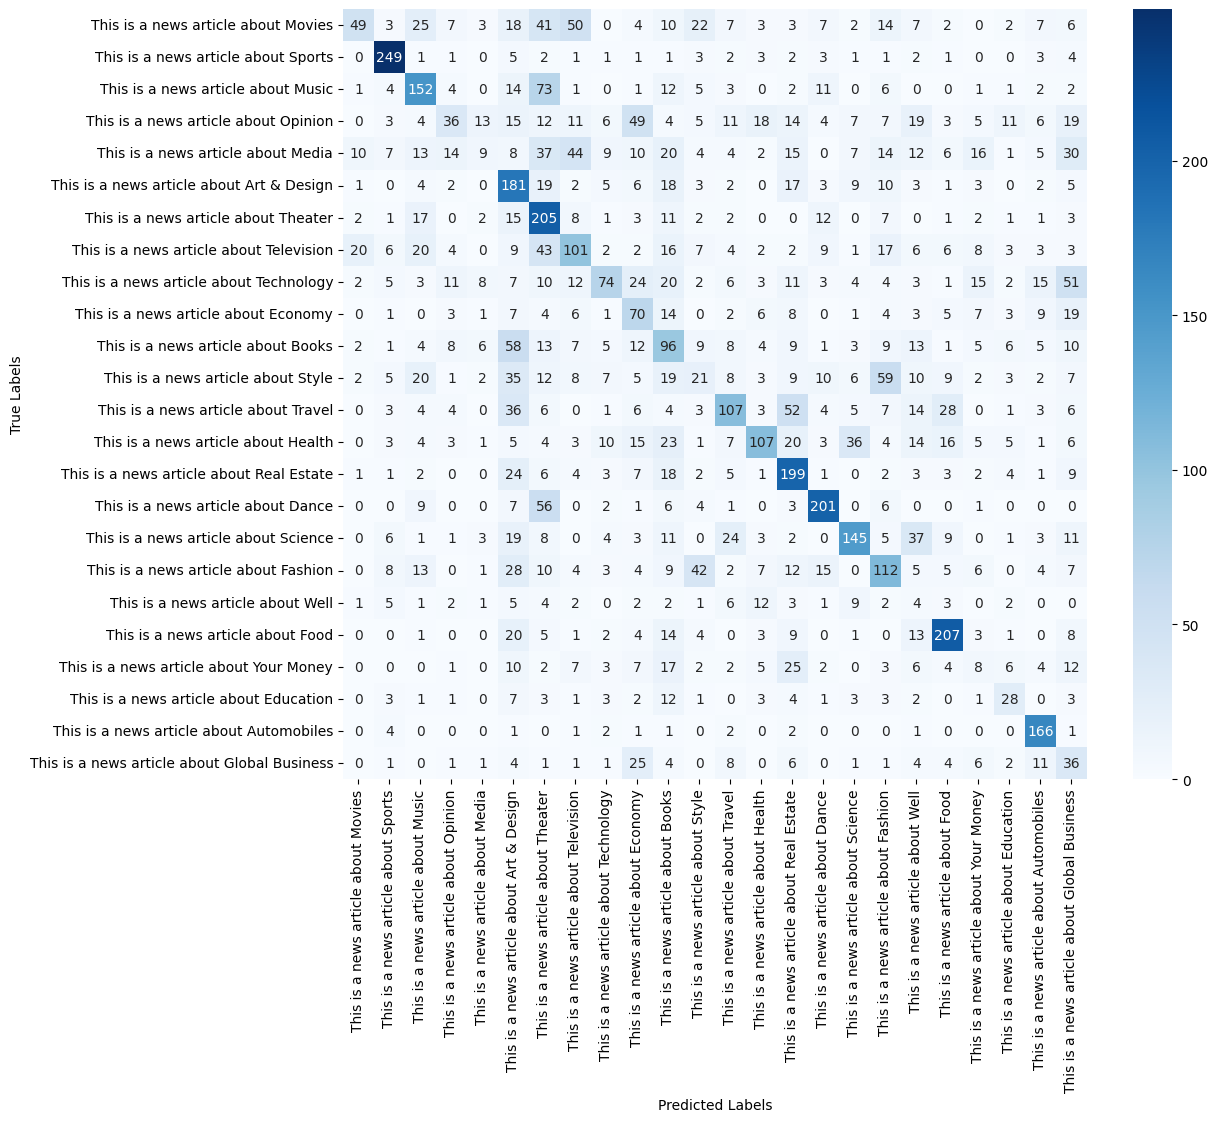

In [13]:
get_predictions(validation_loader, predictions_val, split='val')

Mean F1: 0.3755276502173243


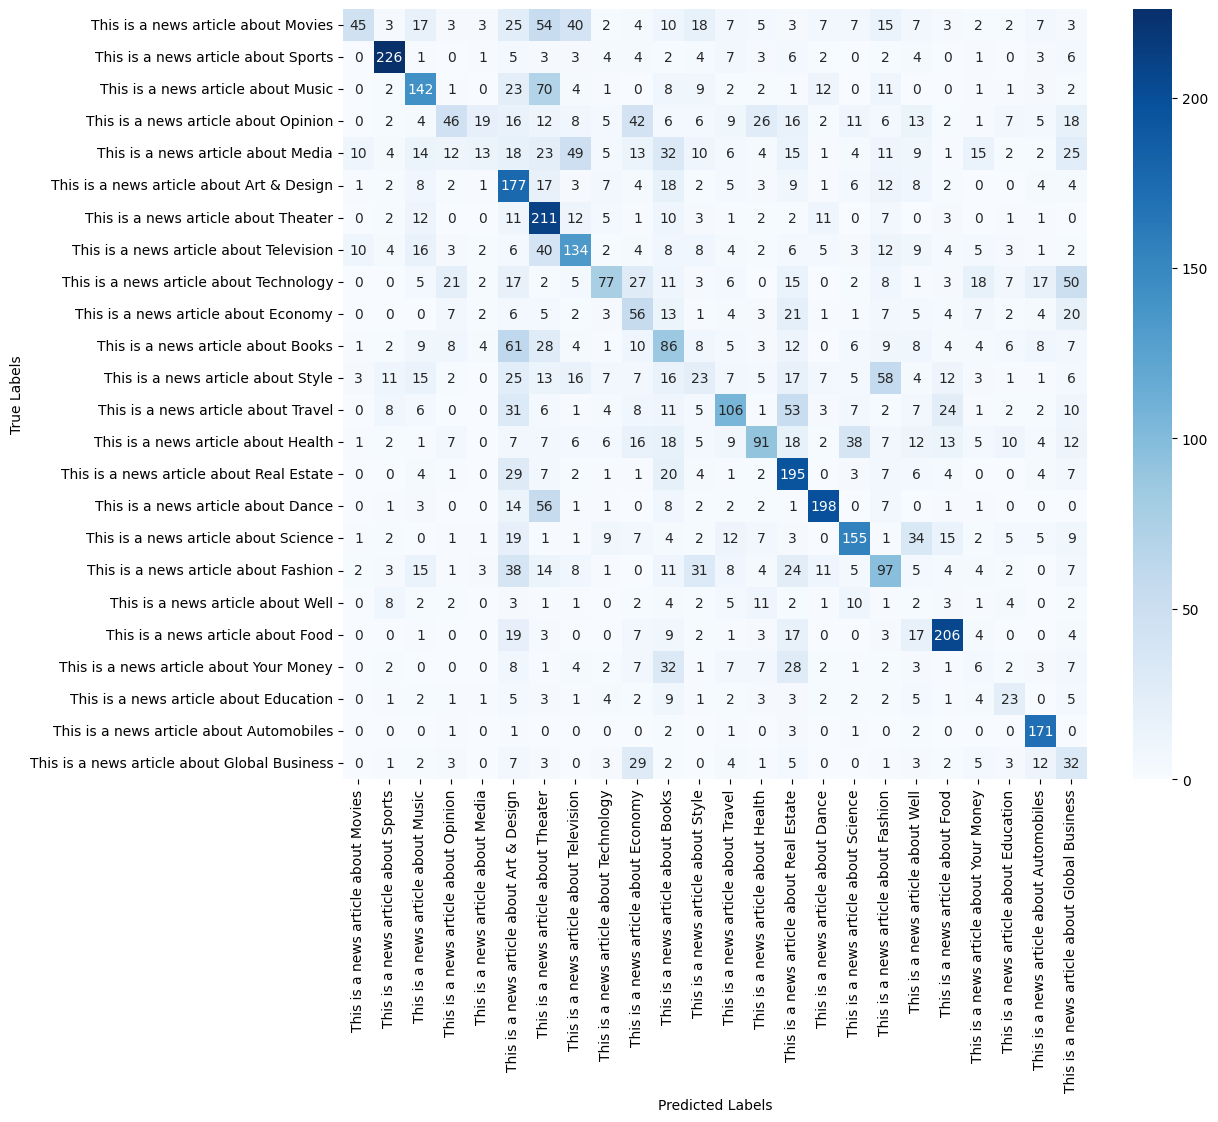

In [14]:
get_predictions(test_loader, predictions_test, split='test')